# Aillio Bullet Roast Data Analysis

In [3]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import statsmodels.api as sm

import dump_roasts

In [34]:
roast_samples_fields = [
    'beanDerivative',
    'beanTemperature',
    'drumTemperature',
]

controls = {
    0: 'power',
    1: 'fan',
    2: 'drum',
}

def set_roast_samples_controls(roast_samples, actions):
    for control_type in controls.values():
        roast_samples[control_type] = None

    control_values = {}
    for action in actions:
        control_name = controls.get(action['ctrlType'], None)
        if control_name is None:
            continue
        
        if control_name not in control_values:
            control_values[control_name] = (0, action['value'])
        else:
            prior_index, prior_value = control_values[control_name]
            control_loc = roast_samples.columns.get_loc(control_name)
            roast_samples.iloc[prior_index:action['index'], control_loc] = prior_value
            control_values[control_name] = (action['index'], action['value'])

    for control_name, (index, value) in control_values.items():
        control_loc = roast_samples.columns.get_loc(control_name)
        roast_samples.iloc[index:, control_loc] = value


def create_roast_samples(roast_json, roast):
    roast_samples_columns = {f:roast_json[f] for f in roast_samples_fields}
    roast_samples = pd.DataFrame.from_dict(roast_samples_columns)
    sample_period = 1 / roast['sampleRate']
    roast_samples['time'] = pd.Series([i * sample_period for i in range(0, len(roast_samples))])
    roast_samples['uid'] = roast['uid']
    roast_samples['smoothDrumTemperature'] = roast_samples['drumTemperature'].ewm(com=0.99).mean()
    #roast_samples['smoothDrumDerivative'] = (roast_samples['drumTemperature'].diff() * 60 / sample_period).ewm(span=50).mean()
    y = (roast_samples['drumTemperature'].diff() * 60 / sample_period).values
    x = roast_samples['time'].values
    roast_samples['smoothDrumDerivative'] = pd.Series(sm.nonparametric.lowess(y, x, frac=0.1)[:,1])
    set_roast_samples_controls(roast_samples, roast_json['actions']['actionTimeList'])

    return roast_samples

    
def load_roasts(roast_dirname):
    roasts = []
    roasts_samples = []

    for roast_filename in os.listdir(roast_dirname):
        roast_pathname = os.path.join(roast_dirname, roast_filename)
        print(f'loading {roast_pathname}')
        with open(roast_pathname, 'r', encoding='utf-8') as roast_file:
            roast_json = json.load(roast_file)

            roast = dump_roasts.create_roast(roast_json)
            roasts.append(roast)

            roast_samples = create_roast_samples(roast_json, roast)
            roasts_samples.append(roast_samples)
    
    all_roasts = pd.DataFrame(roasts).sort_values('dateTime').reset_index(drop=True)
    all_roasts['backToBack'] = all_roasts['roastNumber'] == all_roasts['roastNumber'].shift(1)

    all_roasts_samples = pd.concat(roasts_samples, ignore_index=True)
    return all_roasts, all_roasts_samples

roast_path = os.path.join(os.path.expanduser("~"), "Library/Application Support/roast-time/roasts")
roasts, roasts_samples = load_roasts(roast_path)
roast_filters = [
    roasts['ambient'].notna(),
    roasts['humidity'].notna(),
    roasts['firmware'] >= 540,
    roasts['weightGreen'] > 0,
    roasts['weightRoasted'] > 0,
    roasts['indexYellowingStart'] > 0,
    roasts['indexFirstCrackStart'] > 0,
    roasts['drumChargeTemperature'] > 200,
]

roasts_filter = True
for roast_filter in roast_filters:
    roasts_filter &= roast_filter
roasts = roasts[roasts_filter].reset_index(drop=True)

with pd.option_context("display.min_rows", None, "display.max_rows", 40, "display.max_columns", 40):
    display(roasts)
    
feature_columns = ['ambient', 'humidity', 'weightGreen', 'drumChargeTemperature', 'beanChargeTemperature']
roasts_samples = pd.merge(roasts, roasts_samples, how='left', on='uid')
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 40):
#    display(roasts_samples)


loading /Users/john/Library/Application Support/roast-time/roasts/e87355ed-04cf-4cd0-8553-7f22b7fd8223
loading /Users/john/Library/Application Support/roast-time/roasts/fiYkaXj38XWC-u6RA6RUL
loading /Users/john/Library/Application Support/roast-time/roasts/003f066d-de67-46c2-9cfd-d6003519f99e
loading /Users/john/Library/Application Support/roast-time/roasts/_zMOdgWP6G90K5OoxO6t3
loading /Users/john/Library/Application Support/roast-time/roasts/LBxq8rPVtI7d2MZ-SZ3e3
loading /Users/john/Library/Application Support/roast-time/roasts/de53658a-7a91-410e-973f-7555e693876e
loading /Users/john/Library/Application Support/roast-time/roasts/AZKH7PWei6152-QDrCdWZ
loading /Users/john/Library/Application Support/roast-time/roasts/ad6b9db9-7c5d-4944-894f-2403fe847b3c
loading /Users/john/Library/Application Support/roast-time/roasts/rZSJiU_PxDiJSNTKS7c_H
loading /Users/john/Library/Application Support/roast-time/roasts/a62fb4f5-7fb7-4aa8-9a4b-c0a0421b4adb
loading /Users/john/Library/Application Suppo

,dateTime,uid,roastNumber,roastName,beanId,rating,serialNumber,firmware,hardware,ambient,humidity,weightGreen,weightRoasted,preheatTemperature,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,totalRoastTime,sampleRate,roastStartIndex,indexYellowingStart,indexFirstCrackStart,indexFirstCrackEnd,indexSecondCrackStart,indexSecondCrackEnd,roastEndIndex,backToBack
0,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True
1,1583382477840,ad6b9db9-7c5d-4944-894f-2403fe847b3c,37,Kenya Gatanga v3,f00ed09e-caf5-499a-9897-4cf877aaa4a5,None,1578,540,50462976,14.0,87.0,455.0,390.0,250,156.7,190.6,243.9,209.2,648,2,0,430,966,0,0,0,1301,False
2,1584591714612,b99f9de9-b760-41be-9435-5f779349b469,38,Guatemala Chimaltenango v2 FC,563fec35-e837-4729-aad3-aa50d3b04e9e,None,1578,540,50462976,14.0,64.0,325.0,275.0,240,155.7,187.9,241.1,215.4,522,2,0,328,772,0,0,0,1049,False
3,1585373771446,c988abf5-4859-4fb2-9a91-0149ffd57755,40,Brazil Pedra Branca FC+,5557afb9-121e-45ba-b82a-b64f8f89fb16,None,1578,540,50462976,13.0,69.0,351.0,297.0,240,154.3,202.0,240.9,221.1,621,2,0,362,938,0,0,0,1236,False
4,1586564521813,70b82ad7-b434-41c5-bbc0-2c56bf9a0f3d,41,Ryan Ethiopia Yukiro Coop v3,f00ed09e-caf5-499a-9897-4cf877aaa4a5,None,1578,553,50462976,16.0,67.0,455.0,398.0,250,158.1,196.8,247.0,210.0,661,2,0,388,951,953,1217,1220,1317,False
5,1586565249336,3f030e97-934e-4233-b93b-57321a62364f,41,Yemen Mokha Harasi FC,f679533b-2607-44f0-8004-73accb3a3207,None,1578,553,50462976,16.0,67.0,471.0,398.0,250,163.9,204.5,251.0,215.8,687,2,0,416,913,0,0,0,1379,True
6,1587783233820,d37b17ea-72a4-4831-b174-9999e8a7b9f9,43,Ryan Ethiopia Coop v4,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,553,50462976,27.0,42.0,455.0,399.0,250,171.7,198.6,250.1,208.5,609,2,0,458,888,0,0,0,1224,False
7,1587783933616,5493e552-8e46-4265-a8dc-8271c6dbad86,43,Ethiopia Yukiro Hot Lot,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,553,50462976,27.0,40.0,570.0,497.0,260,175.8,203.2,260.0,210.9,673,2,0,388,1016,0,0,0,1351,True
8,1588557728473,a62fb4f5-7fb7-4aa8-9a4b-c0a0421b4adb,45,Ryan Burundi Kayanza Gahahe #1,83fe4149-bc27-4e6b-8788-e7a68cb92f7e,None,1578,553,50462976,21.0,68.0,455.0,391.0,250,166.5,196.4,250.7,210.2,641,2,0,390,952,0,0,0,1287,False
9,1588998610388,99fc30f4-6b2a-4127-9ca2-d26113598d4e,46,Ethiopia Yukiro FC+ Meg v2,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,553,50462976,18.0,87.0,455.0,390.0,250,161.3,209.9,251.6,220.3,666,2,0,444,926,0,0,0,1338,False


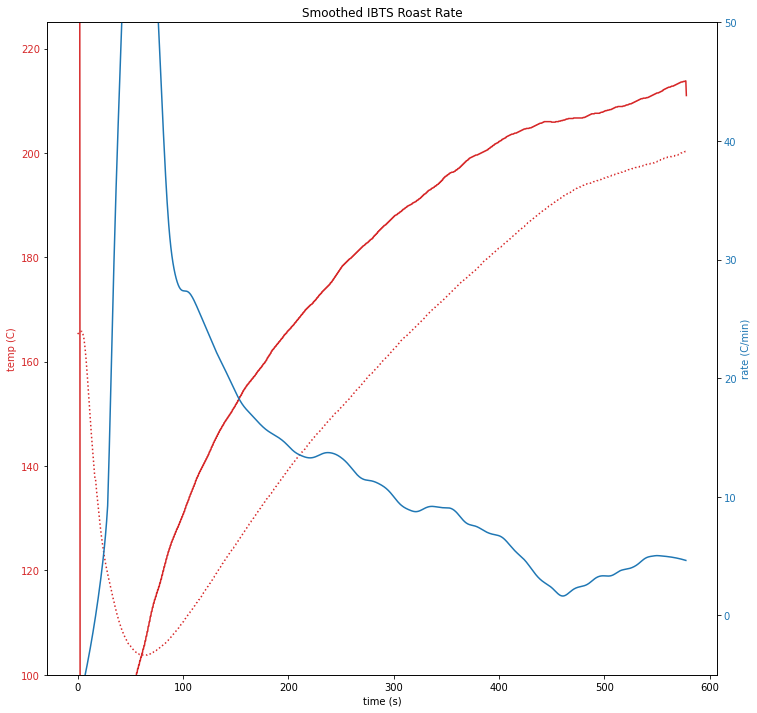

OK


In [51]:
roast_samples = roasts_samples[roasts_samples['uid'] == '3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f']
fig, ax_temp = plt.subplots(figsize=(12, 12))

ax_temp.set_title('Smoothed IBTS Roast Rate')

color_temp = 'tab:red'
ax_temp.set_xlabel('time (s)')
ax_temp.set_ylabel('temp (C)', color=color_temp)
ax_temp.set_ylim((100, 225))
ax_temp.plot(roast_samples['time'], roast_samples['drumTemperature'], color=color_temp)
ax_temp.plot(roast_samples['time'], roast_samples['beanTemperature'], color=color_temp, linestyle=':')
ax_temp.tick_params(axis='y', labelcolor=color_temp)

ax_rate = ax_temp.twinx()
color_rate = 'tab:blue'
ax_rate.set_ylabel('rate (C/min)', color=color_rate)
ax_rate.set_ylim((-5, 50))
ax_rate.plot(roast_samples['time'], roast_samples['smoothDrumDerivative'], color=color_rate)
ax_rate.tick_params(axis='y', labelcolor=color_rate)

plt.show()
print('OK')

## IBTS-Probe Temperature Difference vs Ambient Temperature

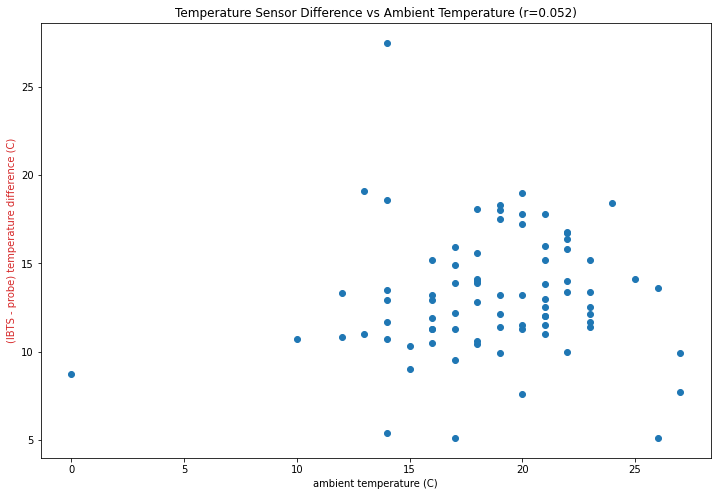

In [52]:
roasts['delta'] = roasts['drumDropTemperature'] - roasts['beanDropTemperature']
#with pd.option_context("display.min_rows", None, "display.max_rows", 100, "display.max_columns", 40):
#    display(roasts[['ambient', 'delta']])

temperature_corr = roasts['ambient'].astype('float64').corr(roasts['delta'].astype('float64'))

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title(f'Temperature Sensor Difference vs Ambient Temperature (r={temperature_corr:.2})')
ax.set_xlabel('ambient temperature (C)')
ax.set_ylabel('(IBTS - probe) temperature difference (C)', color=color_temp)
plt.scatter(roasts['ambient'], roasts['delta'])
plt.show()

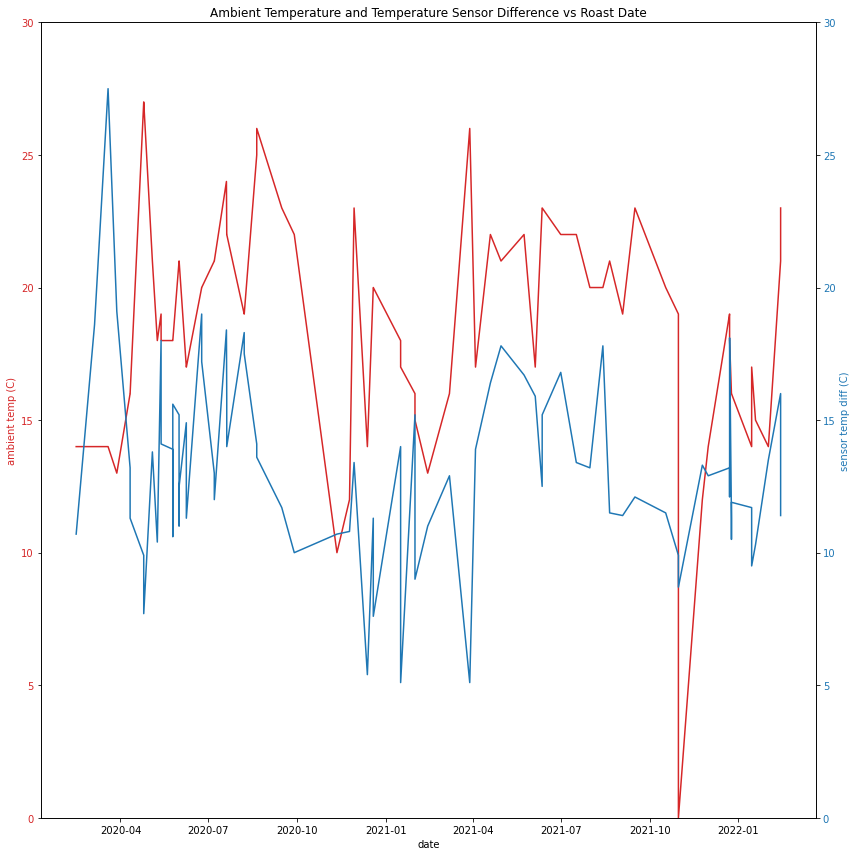

OK


In [53]:
roast_dates = pd.to_datetime(roasts['dateTime'],unit='ms')

fig, ax_temp = plt.subplots(figsize=(12, 12))
ax_temp.set_title(f'Ambient Temperature and Temperature Sensor Difference vs Roast Date')

color_ambient = 'tab:red'
ax_temp.set_xlabel('date')
ax_temp.set_ylabel('ambient temp (C)', color=color_ambient)
ax_temp.set_ylim((0, 30))
ax_temp.plot(roast_dates, roasts['ambient'], color=color_ambient)
ax_temp.tick_params(axis='y', labelcolor=color_ambient)

ax_rate = ax_temp.twinx()
color_delta = 'tab:blue'
ax_rate.set_ylabel('sensor temp diff (C)', color=color_delta)
ax_rate.set_ylim((0, 30))
ax_rate.plot(roast_dates, roasts['delta'], color=color_delta)
ax_rate.tick_params(axis='y', labelcolor=color_delta)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('OK')